<a href="https://colab.research.google.com/github/johanhoffman/DD2363_VT22/blob/hannahklingberg-lab7/Lab7/hannahklingberg_lab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 7: Optimization and Learning**
**Hanna Klingberrg**

# **Abstract**

This lab explores iterative methods to solve minimization problems, aiming to find $x^* \in D$ such that:

$f(x^*) \leq f(x)$ $\forall x \in D$

The algorithms implemented are the Gradient Descent method and Newtons method. The result of the iterative methods are both printed and the iterations plotted, so that the procedure of the algorithms is visualized. Both algorithms performed quite well, however Newtons method was slightly more effective. 

#**About the code**

A short statement on who is the author of the file, and if the code is distributed under a certain license. 

In [ ]:
"""This program is a template for lab reports in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

To have access to the neccessary modules you have to run this cell. If you need additional modules, this is where you add them. 

In [ ]:
# Load neccessary modules.
from google.colab import files

import time
import numpy as np
import scipy.optimize as optimize
from matplotlib import pyplot as plt

#try:
#    from dolfin import *; from mshr import *
#except ImportError as e:
#    !apt-get install -y -qq software-properties-common 
#    !add-apt-repository -y ppa:fenics-packages/fenics
#    !apt-get update -qq
#    !apt install -y --no-install-recommends fenics
#    from dolfin import *; from mshr import *
    
#import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt
from matplotlib import tri
from matplotlib import axes
from mpl_toolkits.mplot3d import Axes3D

# **Introduction**

Finding the maximum or minimum of a function is called an optimization problem. The problems takes the form of finding $x^* \in D$ s.t.

$f(x^*) \leq f(x)$     $∀x \in D$

In this lab, two different iterative methods to find such a minimum are implemented and tested: the gradient descent method and Newtons method. The theory behind each algorithm is described in its corresponding section. 



# **Method**

# **Gradient descent method in Rn**
To find the critical point of a function f(x), the gradient descent function iteratively searches for the critical point by searching in the direction opposite to the gradient of the objective function. At every iteration k the approximation $x^{(k+1)}$ is updated by the formula: 

$x^{(k+1)} = x^{(k)} \alpha^{(k)} \nabla f(x^{(k)}$

(source: chapter 15.3 in course book). 

The algorithm is implemented based on the pseudo code given for algorithm 15.1 (chapter 15.3). The function utilizes the methods ```compute_gradient(f,x)``` and ```line_search(f,x)```. 

```compute_gradient(f,x)```is developed according to the formula given on https://en.wikipedia.org/wiki/Numerical_differentiation:

$\nabla f(x) = (\frac{\partial f}{\partial x_1}, ..., \frac{\partial f}{\partial x_n})$ where each $\frac{\partial f}{\partial x_i} = \frac{f(x+he_i) -f(x)}{h} $ where each $e_i$ is the standard basis vector for $R^n$

For the line_search method, which provides the step length $\alpha$ in which the search direction iterates, I had a bit of trouble implementing it. I ended up testing the function with three different values of $\alpha$ : $[0.01, 0.1, 0.5]$ and plotting the convergence result for each of these. 

To avoid the algorithm getting stuck in a loop, the while loop is limited by both $||\nabla f(x)|| > 10^{-8}$ and iterations < $10^5$.

For the test I used the function $f(x) = x_1^2 + 2x_2^2$ (taken from course book) which has the critical point $(0,0)$. The convergence of the iterative method can be analyzed by saving the result of each iteration in a list and plotting the iterated values together with the true solution. 

In [ ]:
def compute_gradient(f, x):
  h_mat = np.identity(len(x))*10**-5
  grad = np.array([(f(x+h) - f(x))/10**-5 for h in h_mat]) 
  return grad


In [ ]:
def grad_desc(f, x0, alpha):
  iterations = [x0]
  max_iter = 10**5
  iter = 0
  TOL = 10**-8
  x = x0
  df = compute_gradient(f, x)
  while np.linalg.norm(df) > TOL and iter < max_iter:
    df = compute_gradient(f,x)
    x = x - alpha*df
    iterations.append(x)
    iter +=1
  return x, iterations, iter 


In [ ]:
def test_gradient_descent():
  func = lambda x: x[0]**2 + 2*x[1]**2
  x0 = np.array([1,1])
  alphas = [0.01, 0.1, 0.4]
  solutions = []
  for a in alphas: 
    approx, test, iter = grad_desc(func, x0, a)
    plt.plot([x[0] for x in test], label = "approximation of x1")
    plt.plot([x[1] for x in test], label  = "approximation of x2")
    plt.plot([0 for x in test], label = "true value of both x1 and x2")
    plt.legend()
    plt.xlabel("iterations")
    plt.ylabel("value")
    plt.title("gradient descent with alpha = " + str(a) + ", " + str(iter) + " iterations")
    plt.show()
    solutions.append(approx)
  return solutions

# **Newtons Method in Rn**

Newtons method is a minimization method based on the equation:

$f(x) \approx f(y)^T (x-y) + \frac{1}{2}(x-y)^T Hf(y)(x-y)$

where $Hf(y)$ is the Hessian matrix of f evaluated at y, $x = x^{(k+1)}$, and $ y = x^{(k)}$, which allows us to update x iteratively by:

$x^{(k+1)} = x^{(k)} + \nabla x $

where

$\nabla x = -(Hf(x^{(k)}))^{-1} \nabla f(x^{(k)})$

We approximate the Hessian H so that the ith row of the Hessian is: 

$\frac{\nabla f(x+he_i) - \nabla f(x)}{h} $ 

The same function is tested as in the gradient descent method, so that the methods can be compared. The iterative solution is plotted. 


In [ ]:
def compute_hessian(f, x):
  h = 10**-5
  hess = np.zeros((x.shape[0], x.shape[0]))
  for i in range(x.shape[0]):
    xi = list(x)
    xi[i] += h
    hess[i][:] = (compute_gradient(f, xi) - compute_gradient(f,x))/h
  return np.array(hess)

In [ ]:
def newton_minimization(f, x0):
  approx = [x0]
  iter = 0
  max_iter = 10**7
  TOL = 10**-8
  x = np.zeros(x0.shape)
  x[:] = x0[:]
  df = compute_gradient(f, x)
  while np.linalg.norm(df) > TOL and iter < max_iter:
    df = compute_gradient(f,x)
    hf = compute_hessian(f, x)
    dx = np.linalg.solve(hf, -df)
    x += dx
    approx.append(x)
    iter += 1
  return x, approx, iter

In [ ]:
def test_newton():
  func = lambda x: x[0]**2 + 2*x[1]**2
  x0 = np.array([1,1])
  sol, approx, iter = newton_minimization(func, x0)
  plt.plot([x[0] for x in approx], label= "iterative approximation of x1")
  plt.plot([x[1] for x in approx], label="iterative approximation of x2")
  plt.plot([0 for x in approx], label="true value of both x1 and x2")
  plt.legend()
  plt.title("approximated solution convergence, " + str(iter) + " iterations")
  plt.show()
  true = np.array([0,0])
  return sol

# **Results**

#**Gradient Descent**
Below the iterated approximated values of $x_1$ and $x_2$ are plotted with the true critical point of $f(x)$. It can be seen that for a higher alpha, it takes fewer iterations to find the correct value. It is also clearly visualized how a larger value of $\alpha$, i.e. a bigger search step, affects the iteration. 

The result of the approximation is printed, and it is clear that the values are close to the true answer, [0,0].

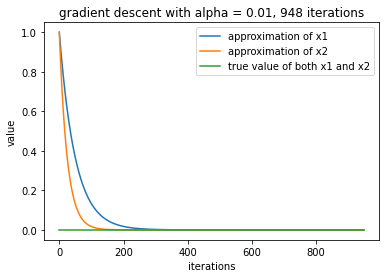

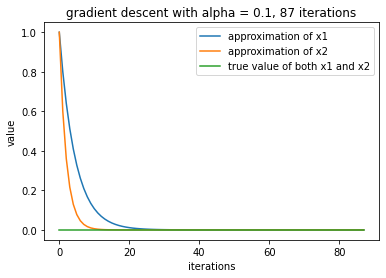

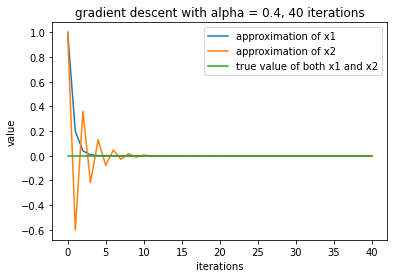

[-4.99518804e-06 -5.00000000e-06]
[-4.99629463e-06 -5.00000000e-06]
[-5.00000000e-06 -4.99866324e-06]


In [ ]:
def tests():
  passed = test_gradient_descent()
  for i in passed:
    print(i)
tests()

# **Newtons Method**

The convergence rate of Newtons Method is plotted below, and the value of the approximated solution is printed. It can be seen that the approximation converges after 3 iterations, and that the given solution is close to the true solution [0,0]. 

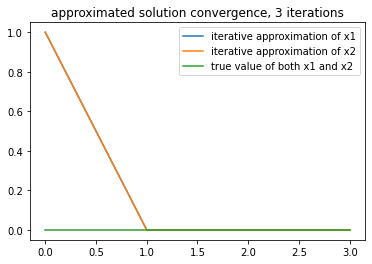

[-5.e-06 -5.e-06]
bajs


In [ ]:
def test():
  passed = np.array(test_newton())
  print(passed)
test()

# **Discussion**

Both methods performed quite well, although it is clear that Newtons minimization method required a lot fewer iterations and thus has better performance. It also has the advantage that the alpha doesn't have to be approximated, although the Hessian is not exact either. 
In the gradient descent method, it is clearly visualized how the value of alpha affects the search method, which I found very interesting. There is also a correlation between the size of alpha and the number of iterations needed.